# Preprocessing and calculation of EMI scores

## Load data

In [1]:
#!pip install datasets
#!pip install gensim

In [1]:
import datasets
from datasets import load_dataset

tldr = load_dataset("webis/tldr-17", split = 'train') # there is only train 


c:\Users\Estelle\miniconda3\envs\docana\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re
import numpy as np
from wordcloud import WordCloud
from matplotlib import cm
from matplotlib.colors import Normalize

## First overview

In [3]:
tldr

Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary'],
    num_rows: 3848330
})

### Colors <3

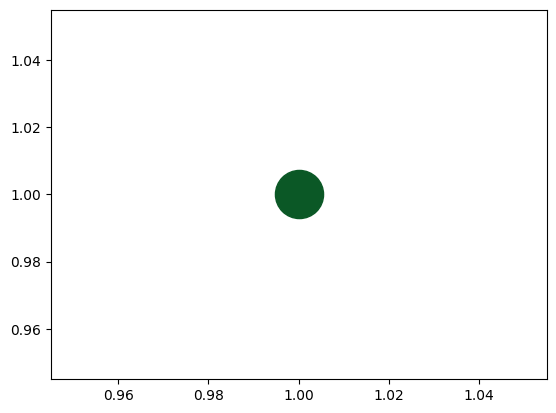

In [4]:
colormap = plt.get_cmap('PRGn')  
plt.scatter(x = [0], y = [0], s =1200, color= colormap(30), label = 'intuition')
plt.scatter(x = [1], y = [1], s =1200, color= colormap(245), label = 'evidence')
intColor = colormap(30)
evColor = colormap(245)
baseColor = colormap(45)

### Subreddits overview

In [3]:
subreddit_count = {}

for subreddit in tldr['subreddit']:
    subreddit_count[subreddit] = subreddit_count.get(subreddit, 0) + 1

In [4]:
subreddit_count

{'math': 1938,
 'funny': 40171,
 'Borderlands': 1506,
 'gamingpc': 553,
 'Diablo': 6860,
 'RedditLaqueristas': 402,
 'apple': 4612,
 'RedditFilmsProduction': 1,
 'AbandonedPorn': 110,
 'atheism': 43268,
 'quotes': 106,
 'AskReddit': 589947,
 'personalfinance': 14403,
 'Animals': 58,
 'leagueoflegends': 109307,
 'videos': 20567,
 'trees': 47286,
 'Games': 11820,
 'rawdenim': 491,
 'BMW': 580,
 'Guitar': 5135,
 'tf2': 7152,
 'truegaming': 5647,
 'swtor': 3681,
 'anime': 5868,
 'relationship_advice': 50416,
 'TwoXChromosomes': 21562,
 'AdviceAnimals': 40783,
 'Minecraft': 8983,
 'motorcycles': 7457,
 'firefall': 248,
 'audiophile': 1175,
 'SRSDiscussion': 642,
 'explainlikeimfive': 25482,
 'WTF': 25781,
 'linux': 2751,
 'LambdaConspiracies': 3,
 'YouShouldKnow': 1045,
 'fffffffuuuuuuuuuuuu': 8542,
 'cars': 4560,
 'TrueAskReddit': 968,
 'boardgames': 3015,
 'childfree': 4364,
 'business': 1096,
 'starcraft': 12911,
 'antisrs': 246,
 'todayilearned': 25004,
 'festivals': 85,
 'askseddit': 3

In [5]:
big_subreddits = {key: value for key, value in subreddit_count.items() if value > 10000}
len(big_subreddits)


49

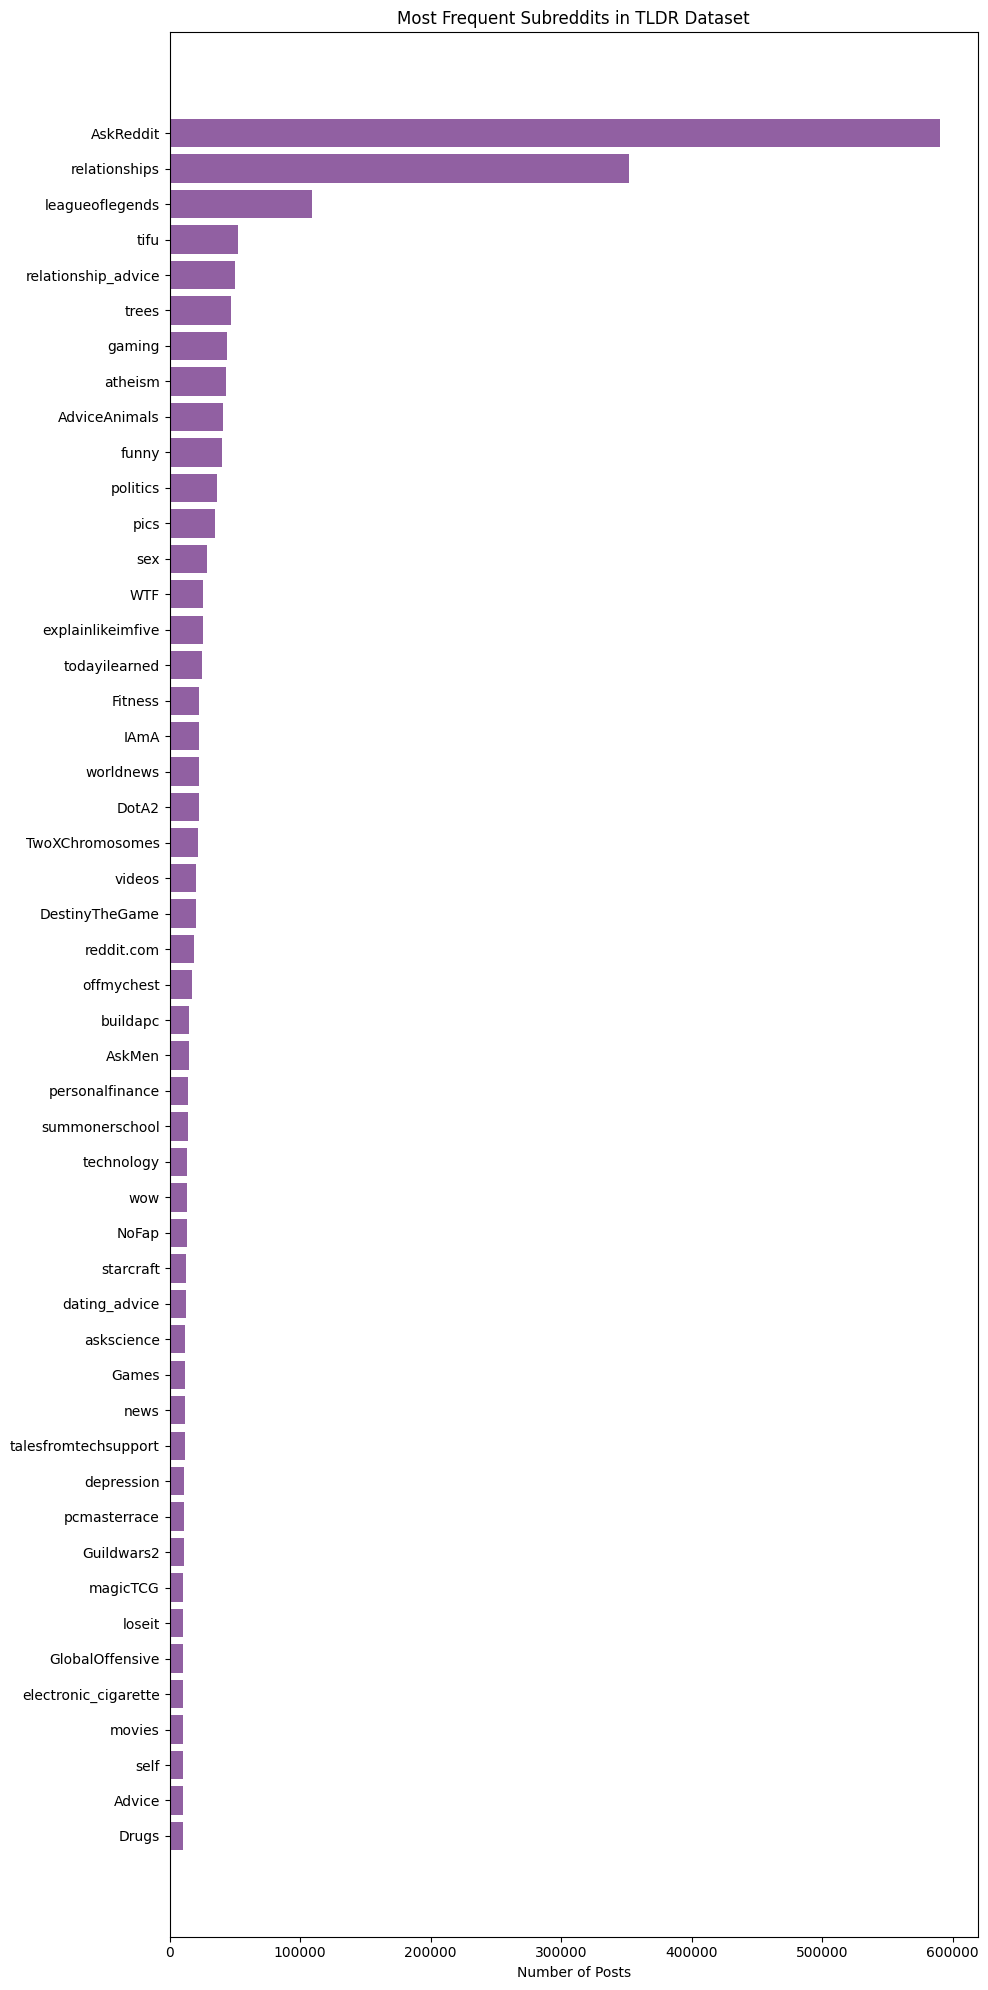

In [8]:
# get labels and values 
sorted_big_subreddits = dict(sorted(big_subreddits.items(), key=lambda item: item[1], reverse=True))
subreddits_labels = list(sorted_big_subreddits.keys())
subreddits_values = list(sorted_big_subreddits.values())

# Plot
plt.figure(figsize=(10, 20))
plt.barh(subreddits_labels, subreddits_values, color=baseColor)
plt.gca().invert_yaxis()  
plt.xlabel("Number of Posts")
plt.title("Most Frequent Subreddits in TLDR Dataset")
plt.tight_layout()
plt.show()

In [6]:
# 'evidence' , 'neutral', 'intuition', 'unknown'
our_guesses = {'AskReddit': 'neutral',
 'relationships': 'intuition',
 'leagueoflegends': 'neutral', # evidence???
 'tifu': 'intuition',
 'relationship_advice': 'intuition',
 'trees': 'evidence',
 'gaming': 'neutral',
 'atheism': 'intuition',
 'AdviceAnimals': 'evidence',
 'funny': 'intuition',
 'politics': 'neutral',
 'pics': 'unknown',
 'sex': 'unknown',
 'WTF': 'intuition',
 'explainlikeimfive': 'evidence',
 'todayilearned': 'evidence',
 'Fitness': 'intuition',
 'IAmA': 'evidence',
 'worldnews': 'evidence',
 'DotA2': 'neutral',
 'TwoXChromosomes': 'neutral',
 'videos': 'unknown',
 'DestinyTheGame': 'unknown',
 'reddit.com': 'unknown',
 'offmychest': 'intuition',
 'buildapc': 'evidence',
 'AskMen': 'intuition',
 'personalfinance': 'neutral',
 'summonerschool': 'neutral',
 'technology': 'evidence',
 'wow': 'neutral',
 'NoFap': 'unknown',
 'starcraft': 'neutral',
 'dating_advice': 'intuition',
 'askscience': 'evidence',
 'Games': 'neutral',
 'news': 'evidence',
 'talesfromtechsupport': 'intuition',
 'depression': 'intuition',
 'pcmasterrace': 'unknown',
 'Guildwars2': 'neutral',
 'magicTCG': 'neutral',
 'loseit': 'intuition',
 'GlobalOffensive': 'neutral',
 'electronic_cigarette': 'neutral',
 'movies': 'intuition',
 'self': 'intuition',
 'Advice': 'intuition',
 'Drugs': 'neutral'}

In [7]:
# selection udpdate
manual_excluded = ['trees', 'WTF', 'IAmA', 'tifu', 'movies', 'self', 'AdviceAnimals', 'atheism', 'funny', 'Fitness']

In [8]:
# save expectations for later comparison
import pickle

selection_expect = {key:value for (key, value) in our_guesses.items() if value in ['evidence', 'intuition'] and key not in manual_excluded}

with open("selection_emi_expect.pkl", "wb") as f:
    pickle.dump(selection_expect, f)

In [9]:
selection = [key for key, value in our_guesses.items() if value in ['evidence', 'intuition'] and key not in manual_excluded]

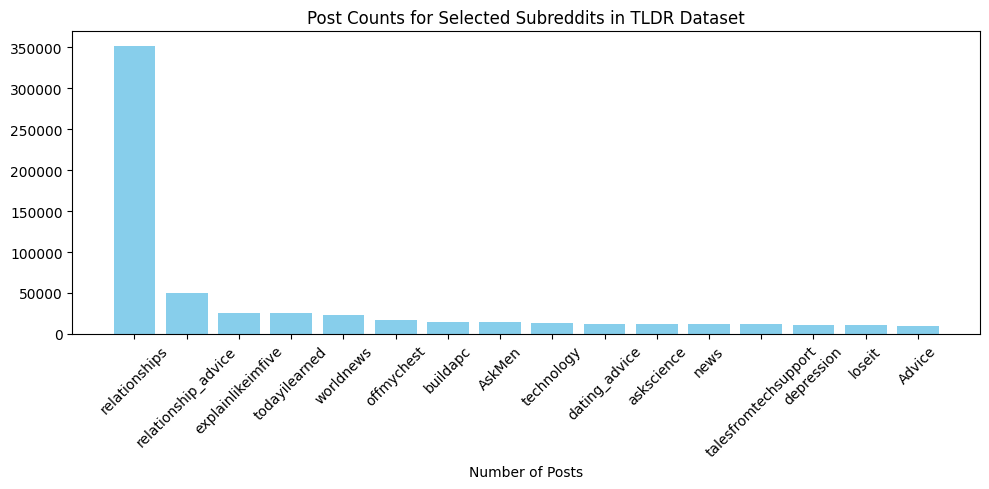

In [10]:
# inspect labels and values of selection subs
selected_subreddits = {key: value for key, value in big_subreddits.items() if key in selection}

sorted_selected_subreddits = dict(sorted(selected_subreddits.items(), key=lambda item: item[1], reverse=True))
subreddits_labels = list(sorted_selected_subreddits.keys())
subreddits_values = list(sorted_selected_subreddits.values())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(subreddits_labels, subreddits_values, color='skyblue')
#plt.gca().invert_yaxis()  
plt.xlabel("Number of Posts")
plt.xticks(rotation=45)
plt.title("Post Counts for Selected Subreddits in TLDR Dataset")
plt.tight_layout()
plt.show()

In [14]:
selection = [i.lower() for i in selection]

In [15]:
print(len(selection))

16


## Preprocessing 

### Tokenization, lowercase, punctuation removal, stopword removal and stemming 

In [15]:
# stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Precompile regex for performance
punctuation_re = re.compile(r"[^\w\s]")

# define clean batch function for map of hugging face dataset
def clean_batch(batch, col = "content", suffix = ''):
    cleaned = []
    for text in batch[col]:
        lowered = text.lower()
        no_punct = punctuation_re.sub("", lowered)
        tokens = word_tokenize(no_punct)
        tokens = [word for word in tokens if word not in stop_words]
        cleaned.append(tokens)
    return {f'clean{suffix}': cleaned}

def clean_batch_wrapper(input_col="content", suffix = ''):
    return lambda example: clean_batch(example, col=input_col, suffix = suffix)

    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ninageyer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sample and train word2vec for EMI 

In [16]:
# sample the reddits of interest

tldr_sample = tldr.filter(lambda example: example["subreddit"].lower() in selection)

Filter: 100%|██████████| 3848330/3848330 [00:36<00:00, 106088.88 examples/s]


In [17]:
# check length
len(tldr_sample)

615392

In [18]:
# clean only the samples
tldr_cleaned_sample = tldr_sample.map(clean_batch_wrapper(), batched=True, batch_size=1000)

Map: 100%|██████████| 615392/615392 [06:24<00:00, 1599.54 examples/s]


In [19]:
# evidence and inutition word list from 'Computational analysis of US congressional speeches reveals a shift from evidence to intuition'
evidence_list = [
    "accurate", "exact", "intelligence", "precise", "search", "analyse", "examination",
    "investigate", "procedure", "show", "analysis", "examine", "investigation", "process",
    "statistics", "correct", "expert", "knowledge", "proof", "study", "correction", "explore",
    "lab", "question", "trial", "data", "fact", "learn", "read", "real", "dossier", "find",
    "logic", "reason", "true", "education", "findings", "logical", "research", "truth",
    "evidence", "information", "method", "science", "truthful", "evident", "inquiry",
    "pinpoint", "scientific"
]

intuition_list = [
    "advice", "doubt", "mislead", "suggestion", "belief", "fake", "mistaken", "suspicion",
    "believe", "fake news", "mistrust", "view", "bogus", "feeling", "opinion", "viewpoint",
    "common sense", "genuine", "perspective", "wrong", "deceive", "guess", "phony",
    "deception", "gut", "point of view", "dishonest", "instinct", "propaganda", "dishonesty",
    "intuition", "sense", "distrust", "lie", "suggest"
]


In [20]:
# train word2vec on samples 
from gensim.models import Word2Vec

# get clean samples and train word2vec
sentences = tldr_cleaned_sample['clean'] 
sentences.append(evidence_list)
sentences.append(intuition_list) 
model = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=1, workers=4)

model.save("word2vec_tldr.model")


### Compute evidence and inutition cosine similarity

In [21]:
# average the vectors per post to calculate similarity to evidence and intuition vectors
def get_avg_vectors(tokens, model):
    
    # Filter tokens that are in the model's vocabulary
    valid_tokens = [token for token in tokens if token in model.wv]
    
    if not valid_tokens:
        return [], [np.zeros(model.vector_size)* len(tokens)] ,np.zeros(model.vector_size)  # Return a zero vector if no valid tokens
    
    # Get vectors for the valid tokens
    word_vectors = np.array([model.wv[token] for token in valid_tokens])
    
    # Compute the average of word vectors
    avg_vector = np.mean(word_vectors, axis=0)
    return valid_tokens, word_vectors, avg_vector

In [22]:
# cosine similarity for map
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    
    if norm_a == 0 or norm_b == 0:
        return 0.0  # Avoid division by zero
    
    return dot_product / (norm_a * norm_b)

In [23]:
# get evidence and intuition vector 
valid_evidence, evidence_vectors, evidence_vector = get_avg_vectors(evidence_list, model)
valid_intuition, inuition_vectors, intuition_vector = get_avg_vectors(intuition_list, model)


In [24]:
# get the evidence and intuition similarity
def compute_scores(example, col = "clean", suffix = ''):
    _, _, avg_vec = get_avg_vectors(example[col], model)
    avg_vec= avg_vec.astype(np.float32)

    evidence_sim = np.float32(cosine_similarity(avg_vec, evidence_vector))
    intuition_sim = np.float32(cosine_similarity(avg_vec, intuition_vector))

    example[f"avg_vec{suffix}"] = avg_vec
    example[f"evidence_sim{suffix}"] = evidence_sim
    example[f"intuition_sim{suffix}"] = intuition_sim
    return example

def compute_score_wrapper(input_col="clean", suffix = ''):
    return lambda example: compute_scores(example, col=input_col, suffix=suffix)

# Map without batching
tldr_cleaned_sample = tldr_cleaned_sample.map(compute_score_wrapper(input_col="clean"), batched=False)

Map: 100%|██████████| 615392/615392 [04:06<00:00, 2497.28 examples/s]


### Get EMI score (z standardised for bins of post length)

In [25]:
# binning 
lengths = [len(post['clean']) for post in tldr_cleaned_sample]

# bins only lengths
bin_edges = pd.qcut(lengths, q=9, retbins=True, labels=False, duplicates='drop')[1]

# function to assign bin no to post 
def assign_bin(example):
    length = len(example['clean'])
    bin_index = np.digitize(length, bin_edges, right=True) 
    return {"length_bin": int(bin_index)}

tldr_cleaned_sample = tldr_cleaned_sample.map(assign_bin)

bin_stats = {}

for bin_id in sorted(set(tldr_cleaned_sample["length_bin"])):
    bin_data = tldr_cleaned_sample.filter(lambda x: x["length_bin"] == bin_id)
    
    evidence_values = bin_data["evidence_sim"]
    intuition_values = bin_data["intuition_sim"]
    
    stats = {
        "evidence_sim_mean": np.mean(evidence_values),
        "evidence_sim_std": np.std(evidence_values, ddof=1),  
        "intuition_sim_mean": np.mean(intuition_values),
        "intuition_sim_std": np.std(intuition_values, ddof=1),  
    }
    
    bin_stats[bin_id] = stats


Filter: 100%|██████████| 615392/615392 [01:24<00:00, 7303.63 examples/s] 


In [26]:
# z by bin 
def center_by_bin(example):
    bin_id = example['length_bin']
    stats = bin_stats[bin_id]

    # Compute z-scores
    z_evidence = (example['evidence_sim'] - stats['evidence_sim_mean']) / stats['evidence_sim_std'] + 1e-20
    z_intuition = (example['intuition_sim'] - stats['intuition_sim_mean']) / stats['intuition_sim_std'] + 1e-20
    
    emi = z_evidence - z_intuition
    
    return {
        'z_evidence': z_evidence,
        'z_intuition': z_intuition,
        'emi': emi
    }
tldr_cleaned_sample = tldr_cleaned_sample.map(center_by_bin)


Map:   0%|          | 0/615392 [00:00<?, ? examples/s]/var/folders/6j/zwb2vl_d44z5c7k8ddqh_b680000gn/T/ipykernel_75733/1545197949.py:7: RuntimeWarning: invalid value encountered in scalar divide
  z_evidence = (example['evidence_sim'] - stats['evidence_sim_mean']) / stats['evidence_sim_std'] + 1e-20
/var/folders/6j/zwb2vl_d44z5c7k8ddqh_b680000gn/T/ipykernel_75733/1545197949.py:8: RuntimeWarning: invalid value encountered in scalar divide
  z_intuition = (example['intuition_sim'] - stats['intuition_sim_mean']) / stats['intuition_sim_std'] + 1e-20
Map: 100%|██████████| 615392/615392 [18:51<00:00, 543.88 examples/s]  


## EMI for the tldr

In [27]:
tldr_cleaned_sample

Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary', 'clean', 'avg_vec', 'evidence_sim', 'intuition_sim', 'length_bin', 'z_evidence', 'z_intuition', 'emi'],
    num_rows: 615392
})

In [28]:

# clean only the samples
tldr_cleaned_sample = tldr_cleaned_sample.map(clean_batch_wrapper(input_col='summary', suffix='_short'), batched=True, batch_size=1000)
#TODO Estelle: hier in der Funktion bzw wrapper die suffixes abändern 

# get clean samples and train word2vec
sentences = tldr_cleaned_sample['clean_short'] #TODO Estelle: hier händisch suffix abändern 
sentences.append(evidence_list)
sentences.append(intuition_list) 
model = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=1, workers=4)

# Map without batching
tldr_cleaned_sample = tldr_cleaned_sample.map(compute_score_wrapper(input_col="clean_short", suffix='_short'), batched=False)#TODO Estelle: hier händisch suffix abändern 

# binning 
lengths = [len(post['clean_short']) for post in tldr_cleaned_sample] #TODO Estelle: hier händisch suffix abändern 

# bins only lengths
bin_edges = pd.qcut(lengths, q=9, retbins=True, labels=False, duplicates='drop')[1]

# function to assign bin no to post 
def assign_bin(example): #TODO Estelle: hier händisch die suffixes abändern 
    length = len(example['clean_short'])
    bin_index = np.digitize(length, bin_edges, right=True) 
    return {"length_bin_short": int(bin_index)}

tldr_cleaned_sample = tldr_cleaned_sample.map(assign_bin)



Map: 100%|██████████| 615392/615392 [01:10<00:00, 8733.91 examples/s] 


In [29]:
#TODO Estelle: hier händisch die suffixes abändern 
bin_stats = {}

for bin_id in sorted(set(tldr_cleaned_sample["length_bin_short"])):
    bin_data = tldr_cleaned_sample.filter(lambda x: x["length_bin_short"] == bin_id)
    
    evidence_values = bin_data["evidence_sim_short"]
    intuition_values = bin_data["intuition_sim_short"]
    
    stats = {
        "evidence_sim_mean_short": np.mean(evidence_values),
        "evidence_sim_std_short": np.std(evidence_values, ddof=1),  
        "intuition_sim_mean_short": np.mean(intuition_values),
        "intuition_sim_std_short": np.std(intuition_values, ddof=1),  
    }
    
    bin_stats[bin_id] = stats



Filter: 100%|██████████| 615392/615392 [02:07<00:00, 4833.73 examples/s]


In [30]:
# z by bin TODO Estelle: hier händisch die suffixes abändern 
def center_by_bin(example):
    bin_id = example['length_bin_short']
    stats = bin_stats[bin_id]

    # Compute z-scores
    z_evidence = (example['evidence_sim_short'] - stats['evidence_sim_mean_short']) / stats['evidence_sim_std_short'] + 1e-20
    z_intuition = (example['intuition_sim_short'] - stats['intuition_sim_mean_short']) / stats['intuition_sim_std_short'] + 1e-20
    
    emi = z_evidence - z_intuition
    
    return {
        'z_evidence_short': z_evidence,
        'z_intuition_short': z_intuition,
        'emi_short': emi
    }
tldr_cleaned_sample = tldr_cleaned_sample.map(center_by_bin)

Map:   0%|          | 0/615392 [00:00<?, ? examples/s]/var/folders/6j/zwb2vl_d44z5c7k8ddqh_b680000gn/T/ipykernel_75733/4238836109.py:7: RuntimeWarning: invalid value encountered in scalar divide
  z_evidence = (example['evidence_sim_short'] - stats['evidence_sim_mean_short']) / stats['evidence_sim_std_short'] + 1e-20
/var/folders/6j/zwb2vl_d44z5c7k8ddqh_b680000gn/T/ipykernel_75733/4238836109.py:8: RuntimeWarning: invalid value encountered in scalar divide
  z_intuition = (example['intuition_sim_short'] - stats['intuition_sim_mean_short']) / stats['intuition_sim_std_short'] + 1e-20
Map: 100%|██████████| 615392/615392 [01:05<00:00, 9353.68 examples/s] 


In [31]:
tldr_cleaned_sample.save_to_disk('tldr_cleaned_sample')

Saving the dataset (14/14 shards): 100%|██████████| 615392/615392 [00:02<00:00, 235814.72 examples/s]


In [ ]:
# saving only EMI column to csv
tldr_df = tldr_cleaned_sample.to_pandas()
emi_data = tldr_df[['subreddit', 'subreddit_id', 'id', 'emi', 'emi_short']]
emi_data.to_csv('data/tldr_cleaned.csv')
